In [182]:
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import matplotlib
import plotly
import plotly.graph_objs as go
from linear_regression import LinearRegression

In [170]:
# Read sqlite query results into a pandas DataFrame
con = sqlite3.connect("../data/kaepora_v1.1.db")
# data = pd.read_sql_query("SELECT NED_host, si_v0, dm15_source  from Events where dm15_source > 0 and si_v0 < 0 and NED_host >0", con)
# data = pd.read_sql_query("SELECT phase, si_v, si_eqw  from Spectra inner join Events ON Spectra.SN = Events.SN where si_v between -20000 and -9000 and si_eqw between 0 and 200 and phase between -20 and 14", con)
data = pd.read_sql_query("SELECT phase, si_v, dm15_source, NED_host from Spectra inner join Events ON Spectra.SN = Events.SN where phase between -20 and 14 and si_v between -20000 and -9000 and dm15_source and NED_host", con)

# Verify that result of SQL query is stored in the dataframe
print(data.head())

con.close()

       Phase          si_v  Dm15_source  NED_host
0 -12.560151 -14859.870968         1.37       8.0
1 -11.562205 -13444.645161         1.37       8.0
2  -9.566313 -12218.116129         1.37       8.0
3  -7.925689 -11746.374194         1.37       8.0
4  -6.572474 -10708.541935         1.37       8.0


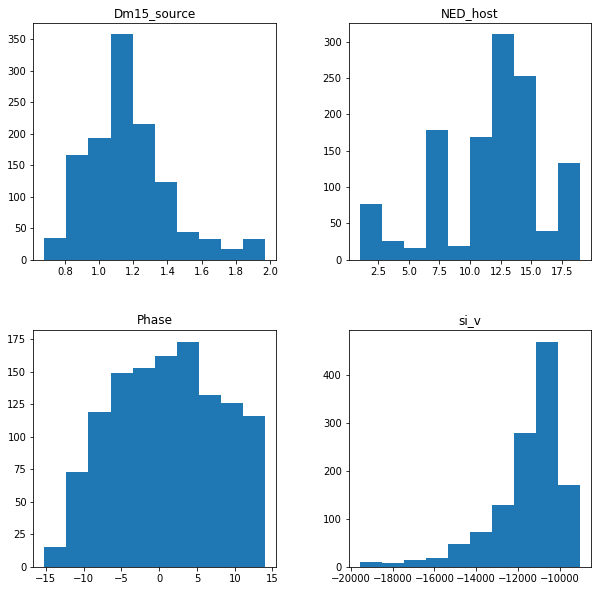

In [171]:
histograms = data.hist(grid=False, figsize=(10, 10))

In [176]:
# train_data = data.sample(frac=0.8)
# test_data = data.drop(train_data.index)
train_data = data.sample(frac=1)
# test_data = data.drop(train_data.index)

In [180]:
input_param_name_1 = 'Phase'
input_param_name_2 = 'si_v'
output_param_name = 'Dm15_source'
color_param = 'NED_host'

In [185]:
# Split training set input and output.
x_train = train_data[[input_param_name_1, input_param_name_2]].values
y_train = train_data[[output_param_name]].values
color_data = train_data[[color_param]].values
print (color_data)
# Split test set input and output.
# x_test = test_data[[input_param_name_1, input_param_name_2]].values
# y_test = test_data[[output_param_name]].values
norm = matplotlib.colors.Normalize(vmin=np.min(color_data),vmax=np.max(color_data))
c_m = matplotlib.cm.plasma
s_m = matplotlib.cm.ScalarMappable(cmap=c_m, norm=norm)
s_m.set_array([])
colors = s_m.to_rgba(color_data.flatten())

[[ 1.]
 [ 8.]
 [10.]
 ...
 [ 2.]
 [12.]
 [17.]]


In [187]:
# Configure the plot with training dataset.
plot_training_trace = go.Scatter3d(
    x=x_train[:, 0].flatten(),
    y=x_train[:, 1].flatten(),
    z=y_train.flatten(),
    name='Training Set',
    mode='markers',
    marker={
        'size': 10,
        'opacity': 1,
        'color': colors,
        'line': {
            'color': colors,
            'width': 1
        },
    }
)

# Configure the plot with test dataset.
# plot_test_trace = go.Scatter3d(
#     x=x_test[:, 0].flatten(),
#     y=x_test[:, 1].flatten(),
#     z=y_test.flatten(),
#     name='Test Set',
#     mode='markers',
#     marker={
#         'size': 10,
#         'opacity': 1,
#         'line': {
#             'color': 'rgb(255, 255, 255)',
#             'width': 1
#         },
#     }
# )

# Configure the layout.
plot_layout = go.Layout(
    title='Date Sets',
    scene={
        'xaxis': {'title': input_param_name_1},
        'yaxis': {'title': input_param_name_2},
        'zaxis': {'title': output_param_name} 
    },
    margin={'l': 0, 'r': 0, 'b': 0, 't': 0}
)

# plot_data = [plot_training_trace, plot_test_trace]
plot_data = [plot_training_trace]

plot_figure = go.Figure(data=plot_data, layout=plot_layout)

# Render 3D scatter plot.
plotly.offline.iplot(plot_figure)

In [144]:
# Set up linear regression parameters.
num_iterations = 500  # Number of gradient descent iterations.
regularization_param = 0  # Helps to fight model overfitting.
learning_rate = 0.01  # The size of the gradient descent step.
polynomial_degree = 0  # The degree of additional polynomial features.
sinusoid_degree = 0  # The degree of sinusoid parameter multipliers of additional features.

# Init linear regression instance.
linear_regression = LinearRegression(x_train, y_train, polynomial_degree, sinusoid_degree)

# Train linear regression.
(theta, cost_history) = linear_regression.train(
    learning_rate,
    regularization_param,
    num_iterations
)

# Print training results.
print('Initial cost: {:.2f}'.format(cost_history[0]))
print('Optimized cost: {:.2f}'.format(cost_history[-1]))

# Print model parameters
theta_table = pd.DataFrame({'Model Parameters': theta.flatten()})
theta_table.head()

Initial cost: 20488771.80
Optimized cost: 10572057.36


,Model Parameters
0,4.137040
1,1.902163
2,1.740709


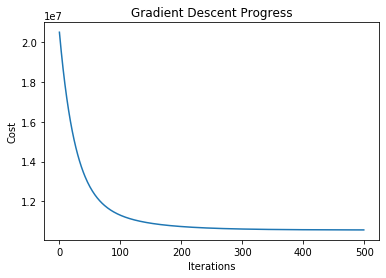

In [145]:

# Plot gradient descent progress.
plt.plot(range(num_iterations), cost_history)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Gradient Descent Progress')
plt.show()

In [146]:
# Generate different combinations of X and Y sets to build a predictions plane.
predictions_num = 10

# Find min and max values along X and Y axes.
x_min = x_train[:, 0].min();
x_max = x_train[:, 0].max();

y_min = x_train[:, 1].min();
y_max = x_train[:, 1].max();

# Generate predefined numbe of values for eaxh axis betwing correspondent min and max values.
x_axis = np.linspace(x_min, x_max, predictions_num)
y_axis = np.linspace(y_min, y_max, predictions_num)

# Create empty vectors for X and Y axes predictions
# We're going to find cartesian product of all possible X and Y values.
x_predictions = np.zeros((predictions_num * predictions_num, 1))
y_predictions = np.zeros((predictions_num * predictions_num, 1))

# Find cartesian product of all X and Y values.
x_y_index = 0
for x_index, x_value in enumerate(x_axis):
    for y_index, y_value in enumerate(y_axis):
        x_predictions[x_y_index] = x_value
        y_predictions[x_y_index] = y_value
        x_y_index += 1

# Predict Z value for all X and Y pairs. 
z_predictions = linear_regression.predict(np.hstack((x_predictions, y_predictions)))

# Plot training data with predictions.

# Configure the plot with test dataset.
plot_predictions_trace = go.Scatter3d(
    x=x_predictions.flatten(),
    y=y_predictions.flatten(),
    z=z_predictions.flatten(),
    name='Prediction Plane',
    mode='markers',
    marker={
        'size': 1,
    },
    opacity=0.8,
    surfaceaxis=2, 
)

plot_data = [plot_training_trace, plot_test_trace, plot_predictions_trace]
plot_figure = go.Figure(data=plot_data, layout=plot_layout)
plotly.offline.iplot(plot_figure)

In [147]:

train_cost = linear_regression.get_cost(x_train, y_train, regularization_param)
test_cost = linear_regression.get_cost(x_test, y_test, regularization_param)

print('Train cost: {:.2f}'.format(train_cost))
print('Test cost: {:.2f}'.format(test_cost))

Train cost: 10572057.36
Test cost: 643095.41


In [148]:
test_predictions = linear_regression.predict(x_test)

test_predictions_table = pd.DataFrame({
    'Si_eqw': x_test[:, 0].flatten(),
    'Si_v': x_test[:, 1].flatten(),
    'Test Phase score': y_test.flatten(),
    'Predicted Phase Score': test_predictions.flatten(),
    'Prediction Diff': (y_test - test_predictions).flatten()
})

test_predictions_table.head(10)

,Si_eqw,Si_v,Test Phase score,Predicted Phase Score,Prediction Diff
0,100.762915,-10897.238710,0.681688,4.202797,-3.521109
1,130.227547,-9859.406452,13.780639,7.816933,5.963706
2,83.937028,-10142.451613,0.998841,3.982628,-2.983788
3,86.210302,-10331.148387,-0.385339,3.893715,-4.279054
4,124.200566,-10897.238710,1.023154,5.948078,-4.924924
5,149.531515,-10048.103226,10.859587,8.996208,1.863379
6,76.834474,-11840.722581,-3.194019,1.130008,-4.324027
7,62.438236,-10519.845161,2.596824,1.865340,0.731484
8,144.149326,-13633.341935,-1.307456,3.689772,-4.997228
9,107.518352,-11274.632258,5.641410,4.189455,1.451956


In [218]:
con = sqlite3.connect("../data/kaepora_v1.1.db")
# data = pd.read_sql_query("SELECT NED_host, si_v0, dm15_source  from Events where dm15_source > 0 and si_v0 < 0 and NED_host >0", con)
# data = pd.read_sql_query("SELECT phase, si_v, si_eqw  from Spectra inner join Events ON Spectra.SN = Events.SN where si_v between -20000 and -9000 and si_eqw between 0 and 200 and phase between -20 and 14", con)
data = pd.read_sql_query("SELECT * from Spectra inner join Events ON Spectra.SN = Events.SN where phase and redshift", con)

# Verify that result of SQL query is stored in the dataframe
print(data.head())

con.close()

                    Filename     SN Source       Phase  MinWave  MaxWave  \
0  sn1989a-19890427-o1i1.flm  1989a  bsnip   83.800000   3450.0   9000.0   
1       sn1989b-19890215.flm  1989b  bsnip    7.469886   3450.0   8450.0   
2       sn1989b-19890221.flm  1989b  bsnip   13.455371   3450.0   7000.0   
3  sn1989b-19890427-o1i1.flm  1989b  bsnip   78.298127   3300.0   9050.0   
4     sn1989b-19890710-o.flm  1989b  bsnip  152.119111   3900.0   6226.0   

          snr                               Interpolated_Spectra      MJD  \
0   11.596532  b'\x84\xa4type\xa3<f8\xa5shape\x92\x03\xcd\x15...  47643.0   
1  211.573494  b'\x84\xa4type\xa3<f8\xa5shape\x92\x03\xcd\x15...  47572.0   
2   12.070824  b'\x84\xa4type\xa3<f8\xa5shape\x92\x03\xcd\x15...  47578.0   
3   56.339961  b'\x84\xa4type\xa3<f8\xa5shape\x92\x03\xcd\x15...  47643.0   
4   14.094985  b'\x84\xa4type\xa3<f8\xa5shape\x92\x03\xcd\x15...  47717.0   

                   Ref  ...  MURES_NO_MSTEP_C_X1  Homogenized_Photometry  \
0  2

In [219]:
kpora_data = set(np.transpose(data['SN'].to_numpy())[0])

In [220]:
print (len(kpora_data))
for SN in kpora_data:
    print (SN)

439
2005am
2006s
2000bh
2004bk
2007nq
2006hx
2012fr
2006py
2011aa
2000dn
2002ha
2006em
1990n
1999dq
1999aa
2009y
1998dh
2006az
2006gt
2003hv
2001cj
2001eh
2002eh
2001g
1995bd
1999bh
1989m
2007bj
2009ab
2001ay
2006cc
2005ku
2012dn
1996bo
2007jg
2007au
2000dm
2000cx
2006te
2007ci
2006ak
2002cf
2003hs
2007ax
2011by
2009Y
2005al
2001ep
2002cr
2007fs
1998de
2008r
2008bt
1999x
2007bz
2004bv
2004dt
2007f
1998v
2006bq
2004eo
snf20080623-001
2003ic
1989a
2003du
1993z
2005ao
2006dd
1998bp
2002fk
2000dk
2008hs
2004ey
1997do
2008bf
2013dy
1996ai
2008z
2004gs
2007ux
2004bl
2004fz
2002db
2006bw
2003cq
2004l
asassn-14lp
2004bg
2007ai
2002dl
2006cf
2008hv
1997e
2007ba
2016itd
1993y
1995e
2009an
1992a
2006cs
2005mz
1994d
2002g
2002ef
2004fu
2006os
2007cp
2006d
2007aj
2001l
2006qo
1997bq
2016ekg
2007qe
2009f
2005ag
2008dx
2016fff
1997br
2005lz
2011iv
1998ab
2002cs
2002hw
2006n
2006bh
1999ej
snf20080514-002
2016gsb
2005lu
2000e
2002kf
2006et
2002dp
2006x
2006gr
2006mo
2006oa
2005el
1996z
2004br
2003kf
19